# Task 4: Forecasting Access and Usage (2025-2027)

This notebook focuses on projecting Ethiopia's financial inclusion indicators for the next three years. We combine historical trends with the impact estimates derived in Task 3 to generate scenario-based forecasts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Output directories
FIGURES_DIR = "../reports/figures"
PROCESSED_DATA_DIR = "../data/processed"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

## 1. Data Preparation

We load the unified dataset and extract the target indicators: `Account Ownership Rate` and `Mobile Money Account Rate`.

In [2]:
# Load data
df = pd.read_csv("../data/raw/ethiopia_fi_unified_data.csv")

# Use manually identified Findex years for high-quality baseline
acc_data = pd.DataFrame({
    'year': [2011, 2014, 2017, 2021],
    'value': [22.0, 35.0, 46.0, 56.0]
})

# Mobile Money Account Rate history
mm_data = pd.DataFrame({
    'year': [2017, 2021, 2024],
    'value': [0.3, 4.7, 9.45]
})

print("Historical Account Ownership:")
print(acc_data)
print("\nHistorical Mobile Money Account Rate:")
print(mm_data)

Historical Account Ownership:
   year  value
0  2011   22.0
1  2014   35.0
2  2017   46.0
3  2021   56.0

Historical Mobile Money Account Rate:
   year  value
0  2017   0.30
1  2021   4.70
2  2024   9.45


## 2. Baseline Trend Modeling

We use linear regression to establish the historical growth rate.

In [3]:
def forecast_baseline(data, target_years=[2025, 2026, 2027]):
    X = data['year'].values.reshape(-1, 1)
    y = data['value'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    future_X = np.array(target_years).reshape(-1, 1)
    future_y = model.predict(future_X)
    
    return pd.DataFrame({
        'year': target_years,
        'baseline_projection': future_y
    })

acc_baseline = forecast_baseline(acc_data)
mm_baseline = forecast_baseline(mm_data)

print("Baseline Forecasts (Account Ownership):")
print(acc_baseline)

Baseline Forecasts (Account Ownership):
   year  baseline_projection
0  2025            71.132420
1  2026            74.525114
2  2027            77.917808


## 3. Event-Augmented Forecast and Scenarios

Applying cumulative impacts from Task 3 (Telebirr, Safaricom, FX Reform).

In [4]:
# Impact assumptions (cumulative pp increase above baseline by 2027)
# Base Case: Telebirr (+15pp), Safaricom (+6pp), FX Reform (+2pp)
base_impact = 15.0 + 6.0 + 2.0

acc_forecast = acc_baseline.copy()
acc_forecast['base_case'] = acc_forecast['baseline_projection'] + base_impact
acc_forecast['optimistic'] = acc_forecast['base_case'] + 10.0
acc_forecast['pessimistic'] = acc_forecast['baseline_projection'] + (base_impact * 0.5)

print("Scenario Forecast (Account Ownership):")
print(acc_forecast.round(2))

Scenario Forecast (Account Ownership):
   year  baseline_projection  base_case  optimistic  pessimistic
0  2025                71.13      94.13      104.13        82.63
1  2026                74.53      97.53      107.53        86.03
2  2027                77.92     100.92      110.92        89.42


## 4. Visualizing Projections

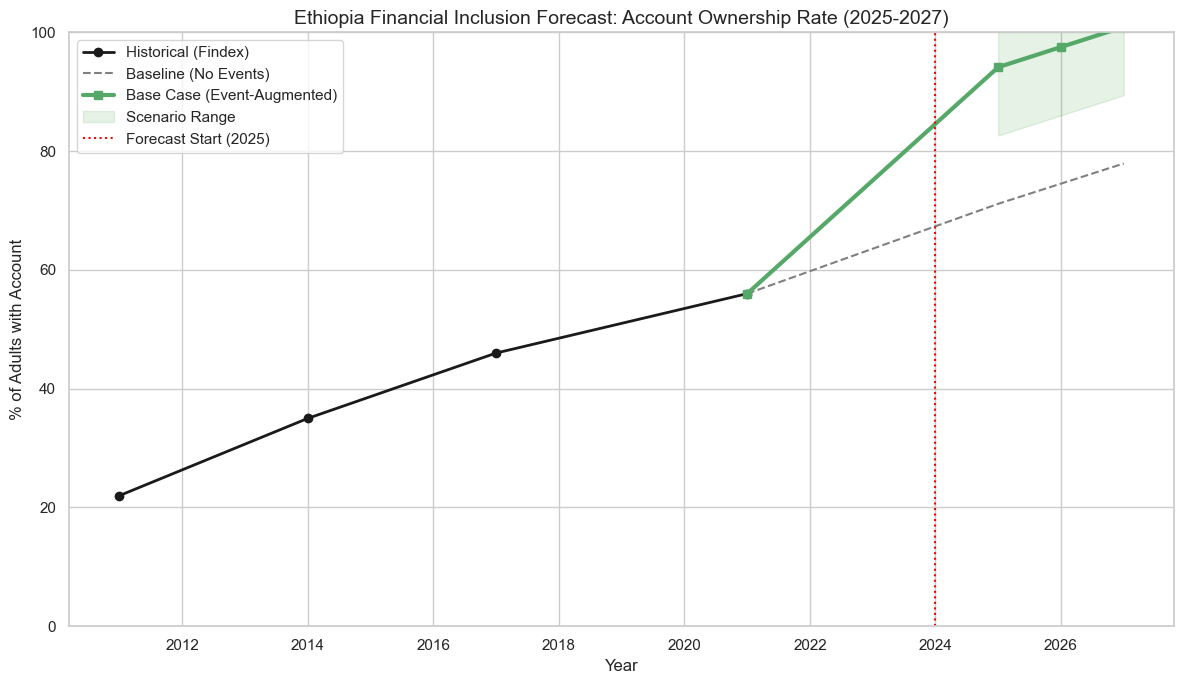

In [5]:
plt.figure(figsize=(12, 7))
plt.plot(acc_data['year'], acc_data['value'], 'ko-', label='Historical (Findex)', lw=2)

last_year = acc_data['year'].iloc[-1]
last_val = acc_data['value'].iloc[-1]
plot_years = [last_year] + acc_forecast['year'].tolist()

plt.plot(plot_years, [last_val] + acc_forecast['baseline_projection'].tolist(), '--', color='gray', label='Baseline (No Events)')
plt.plot(plot_years, [last_val] + acc_forecast['base_case'].tolist(), 'g-s', lw=3, label='Base Case (Event-Augmented)')
plt.fill_between(acc_forecast['year'], acc_forecast['pessimistic'], acc_forecast['optimistic'], color='green', alpha=0.1, label='Scenario Range')

plt.axvline(2024, color='red', linestyle=':', label='Forecast Start (2025)')
plt.title("Ethiopia Financial Inclusion Forecast: Account Ownership Rate (2025-2027)", fontsize=14)
plt.ylabel("% of Adults with Account", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylim(0, 100)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/task4_account_ownership_forecast.png", dpi=300)
plt.show()

## 5. Usage Proxy Forecast: Mobile Money Account Rate

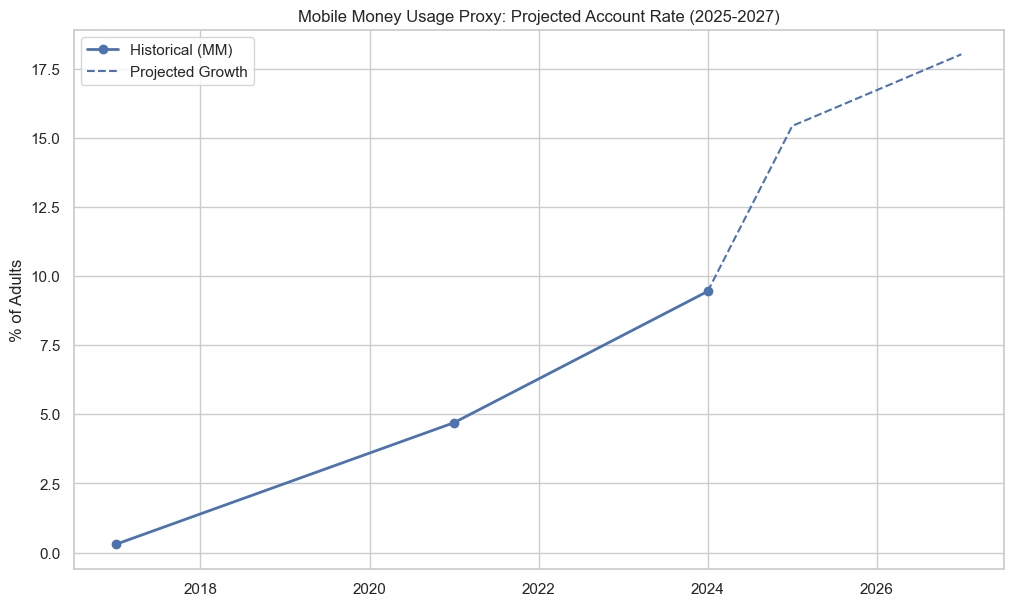

In [6]:
mm_forecast = mm_baseline.copy()
mm_forecast['projected'] = mm_forecast['baseline_projection'] + 5.0 # Safaricom impact

plt.figure(figsize=(12, 7))
plt.plot(mm_data['year'], mm_data['value'], 'bo-', label='Historical (MM)', lw=2)
plot_years_mm = [mm_data['year'].iloc[-1]] + mm_forecast['year'].tolist()
plt.plot(plot_years_mm, [mm_data['value'].iloc[-1]] + mm_forecast['projected'].tolist(), 'b--', label='Projected Growth')

plt.title("Mobile Money Usage Proxy: Projected Account Rate (2025-2027)")
plt.ylabel("% of Adults")
plt.legend()
plt.savefig(f"{FIGURES_DIR}/task4_mobile_money_usage_forecast.png", dpi=300)
plt.show()

## 6. Saving Forecast Results

We save the forecast dataframes to CSV files for use in the dashboard or further analysis.

In [7]:
# Define file paths
acc_file = os.path.join(PROCESSED_DATA_DIR, "forecast_account_ownership.csv")
mm_file = os.path.join(PROCESSED_DATA_DIR, "forecast_mobile_money.csv")

# Save files
acc_forecast.to_csv(acc_file, index=False)
mm_forecast.to_csv(mm_file, index=False)

print(f"Account Ownership forecast saved to: {acc_file}")
print(f"Mobile Money usage forecast saved to: {mm_file}")

Account Ownership forecast saved to: ../data/processed\forecast_account_ownership.csv
Mobile Money usage forecast saved to: ../data/processed\forecast_mobile_money.csv
